In [1]:
#Load edges and nodes

import numpy as np
from load_data import *

nodes_array, edge_array = assert_edges_are_within_first_cluster()

node_lookup_dict = {}

min_index = np.amin(nodes_array)
max_index = np.amax(nodes_array)


i = 0
for node in nodes_array:
    node_lookup_dict[str(node)] = i
    i+= 1
    
adj_matrix = np.load('adj_matrix.npy')    
data_dir = '../data/'

98753it [00:00, 925717.15it/s]
2004it [00:00, 1210627.28it/s]


In [2]:
#Get dois from the exosome csv
#Read the DOIS from the node id

from load_data import *

import csv

csv_file_path = data_dir + 'exosome.csv'

# Open the CSV file for reading
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    dois = {}
    for line_number, row in tqdm(enumerate(csv_reader), total = 14695476):  # 'total' is the total number of iterations
        
        if line_number <min_index or line_number > max_index:
            continue
            
        id = int(row[0])
        doi = row[2]
        
        if id in node_lookup_dict:
            node_lookup_dict[id] = doi



100%|██████████| 14695476/14695476 [00:33<00:00, 444663.43it/s]


In [3]:
#Save
import json

with open('first_cluster_dois.json', 'w') as json_file:
    json.dump(node_lookup_dict, json_file, indent=4)
    


In [ ]:
#Get PMID by doi

import requests
import xmltodict

doi_dict = {}

#Get dois
def fetch_pmid_from_doi(doi='10.1073/pnas.0510928103'):

    pmid_dict = {}
    request_str = 'https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?tool=my_tool&email=my_email@example.com&ids='
    request_str += str(doi)
    
    response = requests.get(request_str)
    response_text = response.text
    
    if response.status_code == 200:
        index = response_text.index('pmid=')


        pmid_whole = response_text[index:].split(' ')[0]
        pmid = int(pmid_whole[:-1].split('\"')[1])

        return pmid
    
    else:
        return 0
    

for key in tqdm(node_lookup_dict.keys()):
    doi_dict[key] = fetch_pmid_from_doi(key)
    

In [ ]:
#It turns out that initial node ids is their PMID


for key, value in doi_dict.items():
    assert key == value
    

with open('first_cluster_pmid.json', 'w') as json_file:
    json.dump(doi_dict, json_file, indent=4)
    

In [ ]:
import json

with open('first_cluster_pmid.json', 'r') as json_file:
    doi_dict = json.load(json_file)
    
pmid_dict = doi_dict

In [ ]:
#Save all xmls
all_xmls = {}
def save_all_xmls(pmid):
    wait = 0.25
    time.sleep(wait)
    pmid_dict = {}
    request_str  = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id='
    request_str += str(pmid)
    
    response = requests.get(request_str)
    response_text = response.text
    
    try:
        xml_dict = xmltodict.parse(response_text)
        
    except:
        time.sleep(2 * wait)
        return fetch_metadata_from_pmid(pmid)
    
    return response_text

# for id in tqdm(pmid_dict):
#     all_xmls[id] = save_all_xmls(id)

with open('first_cluster_xmls.json', 'w') as json_file:
    json.dump(all_xmls, json_file, indent=4)
    




In [5]:
#Load all XMLs
import json

with open('first_cluster_xmls.json', 'r') as json_file:
    all_xmls = json.load(json_file)

In [6]:
#Mispelled
import time
import requests
import xmltodict

parsed_error = []
dict_of_interest = {'keyword': 0, "grant": 0, "abstract": 0, "mesh": 0, "chemicallist":0, 'datecompleted': 0}


def fetch_metadata_from_pmid(response_text, idx, pmid): 
    global dict_of_interest
    mesh_headings = []
    grants = []
    year = ""
    journal_ISSN = ""
    abstract = ""
    chemical_list = []
    meta_data = {}
    
    try:
        xml_dict = xmltodict.parse(response_text)
        
        for key_of_interest in dict_of_interest.keys():
            if key_of_interest in str(xml_dict).lower():

                dict_of_interest[key_of_interest] += 1

        #Date completed or revised?
        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation'].keys())
        
        
        try:
            if 'DateCompleted' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
                if 'Year' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['DateCompleted']:
                    year = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['DateCompleted']['Year']

            else:
    #             print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation'])
                  pass
    
        except:
            pass


        
        try:
            
            if 'ISSN' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal'].keys():
                journal_ISSN = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal']['ISSN']['#text']
        
        except:
            pass
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant']))
        
        
        #Grant
        #Very few grants don't have grant id's
        #Grant institute could also be relevant
        #TODO: collect missing grant id

        try:
            if 'GrantList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']:
                for grant in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant']:
                    if 'GrantID' in grant and 'Agency' in grant:
                        grants.append((grant['GrantID'],grant['Agency']))
                        
        except:
            pass
        
        
        try:
            
            if 'Abstract' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article'].keys():
                if 'AbstractText'  in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Abstract'].keys():
                    abstract = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Abstract']['AbstractText']
        except:
            pass
        
 

        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant'][0])
        
        #MeSH heading  
        
        try:
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']))
        
            #DescriptorName? Is a term
            if 'MeshHeadingList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
                for mesh in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']:
    #                 print(mesh['DescriptorName'])
    #                 print(mesh['DescriptorName']['@UI'])
    #                 print(mesh['DescriptorName']['#text'])
                    mesh_headings.append((mesh['DescriptorName']['@UI'], mesh['DescriptorName']['#text']))
        except:
            pass
        
        
        try:
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']))
        
            #DescriptorName? Is a term
            if 'ChemicalList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
#                print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']
# #                      ['ChemicalList']['Chemical']['NameOfSubstance'])
               #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['ChemicalList']['Chemical']))
               for substance in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['ChemicalList']['Chemical']:
                        chemical_list.append(substance['NameOfSubstance']['@UI'])
                #print(chemical_list)
                
               
              

        except:
            pass
        


        #References and history
        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['PubmedData'].keys())


    except:
        parsed_error.append(idx)
        pass


 
        
    meta_data = {'mesh': mesh_headings, 'grants': grants, 'year': year, 'journal': journal_ISSN,
                 'abstract': abstract, 'chemical' : chemical_list} 
        
    return meta_data

metadata_dict = {}

# [166, 719, 1672, 1918] odd

idx = 0
for key, value in tqdm(all_xmls.items()):
    metadata_dict[key] = fetch_metadata_from_pmid(value, idx, key)
    idx += 1
    


print(f'failed parse {len(parsed_error)}')
print(f'Occured keyword dict: {dict_of_interest}')

100%|██████████| 2004/2004 [00:03<00:00, 549.38it/s]

failed parse 0
Occured keyword dict: {'keyword': 19, 'grant': 139, 'abstract': 962, 'mesh': 1990, 'chemicallist': 1085, 'datecompleted': 1991}


In [7]:
#### Count incomplete data

features = {'mesh': 0, 'grants': 0, 'year': 0, 'journal': 0, 'abstract': 0, 'chemical' : 0}
#Mesh terms are sometimes unrelated

mesh_length = []
chemical_length = []

for feature in features.keys():
    for _, meta in metadata_dict.items():
        if len(meta[feature]) > 0:
            features[feature] += 1
            if feature == 'mesh':
                mesh_length.append(len(meta[feature]))
            
            elif feature == 'chemical':
                chemical_length.append(len(meta[feature]))
                
            
print("Ocurred features ", features)
print("avg mesh length ", np.mean(mesh_length))
print("avg chemical length ", np.mean(chemical_length))

Ocurred features  {'mesh': 1982, 'grants': 57, 'year': 1991, 'journal': 1960, 'abstract': 853, 'chemical': 786}
avg mesh length  9.55247225025227
avg chemical length  4.283715012722646


In [11]:
import json

with open('first_cluster_metadata.json', 'w') as json_file:
    json.dump(metadata_dict, json_file, indent=4)
    


In [12]:
import json

# Load the metadata file
with open('first_cluster_metadata.json', 'r') as json_file:
    metadata_dict = json.load(json_file)

In [13]:
def calculate_dict_similarity(dict_1, dict_2, mode ):
    similarity = 0
    modes = ['number_of_common_terms', 'jaccard']
    
    assert mode in modes
    
    for key in dict_1:
            if key in dict_2:
                similarity += 1
                
    
    if mode == 'number_of_common_terms':
        pass
       
    elif mode == 'jaccard':
        similarity = similarity / (len(dict_1) + len(dict_2))
        
    
    return similarity

In [14]:
#Calculate distance/similarity between two pmid's
#Lets call it metric for now. This is unnormalized
def calculate_distance(pmid1, pmid2, feature):
    
    metric = 0
    pmid1 = str(pmid1)
    pmid2 = str(pmid2)
    
    assert feature in ['year', 'mesh', 'chemical', 'co-citation', 'bib-coupling']
    if feature == 'year':             
                year1 = metadata_dict[pmid1][feature]
                year2 = metadata_dict[pmid2][feature]
                
                if len(year1) > 0 and len(year2)>0:
                    metric = np.abs(int(year1)-int(year2))
                
                else:
                    metric = -1
    
    
    #They are both treated the same way ...
    elif feature == 'mesh' or feature == 'chemical':
        common_terms = 0
        terms_1 = {}
        terms_2 = {}
        
        for term in metadata_dict[pmid1][feature]:
            terms_1[term[0]] = 1
    
        for term in metadata_dict[pmid2][feature]:
            terms_2[term[0]] = 1
        
        if len(terms_1) > 0 and len(terms_2)>0:
            metric = calculate_dict_similarity(terms_1, terms_2, 'jaccard')
                    
        else:
            metric = -1
            
    elif feature == 'bib-coupling':
        node_1 = node_lookup_dict[pmid1]
        node_2 = node_lookup_dict[pmid2]
        
        common = np.dot(adj_matrix[node_1,:], adj_matrix[node_2, :])
        denom = np.sum(adj_matrix[node_1, :]) + np.sum(adj_matrix[node_2, :]) - common
        
        if denom > 0 :
            metric = common / denom
        
    
    elif feature == 'co-citation':
        node_1 = node_lookup_dict[pmid1]
        node_2 = node_lookup_dict[pmid2]
        
        common = np.dot(adj_matrix[: , node_1], adj_matrix[: , node_2])
        denom = np.sum(adj_matrix[:, node_1]) + np.sum(adj_matrix[:, node_2]) - common
        
        if denom > 0 :
            metric = common / denom
    return metric
        

    

In [28]:
def calculate_three_hop_similarity():
    #Is currently inefficient as relies on matrix multiplication
    # We use undirected edges
    aggregated_three_hop_similarity = np.zeros_like(adj_matrix)
    undirected_adj_matrix = adj_matrix + adj_matrix.transpose()
    second_hop_distance = np.matmul(undirected_adj_matrix, undirected_adj_matrix)
    
    three_hop_distance = np.matmul(second_hop_distance, undirected_adj_matrix)
    
    for i in range(adj_matrix.shape[0]):
        for j in range(i):
            similarity = 0
            if undirected_adj_matrix[i][j] == 1:
                similarity = 1
            
            elif second_hop_distance[i][j] > 0:
                similarity = 2/3
            
            elif three_hop_distance[i][j] > 0:
                similarity = 1/3
            
            aggregated_three_hop_similarity[i][j] = similarity
    
    aggregated_three_hop_similarity = aggregated_three_hop_similarity + aggregated_three_hop_similarity.transpose()
    return aggregated_three_hop_similarity

aggregated_three_hop_similarity = calculate_three_hop_similarity()
np.save('aggregated_three_hop_similarity.npy', aggregated_three_hop_similarity)
    

In [26]:
!ls
!rm aggregated_three_hop_distance

adj_matrix.npy			    first_cluster_metadata.json
aggregated_three_hop_distance.npy   first_cluster_pmid.json
bib_coupling_matrix.npy		    first_cluster_pmidn
bib_coupling_similarity_matrix.npy  first_cluster_xmls.json
chemical_similarity_matrix.npy	    load_data.py
cocitation_matrix.npy		    mesh_similarity_matrix.npy
cocitation_similarity_matrix.npy    obtain_features.ipynb
create_metrices.py		    output.tsv
extract_doi.py			    __pycache__
first_cluster_dois.json		    year_distance_matrix.npy
rm: cannot remove ‘aggregated_three_hop_distance’: No such file or directory


In [16]:
#all mesh terms are tuples, so we use UI's as they are standard

ones = 0
twos = 0

for key, value in metadata_dict.items():
    if len(value['mesh']) >0:
        for mesh in value['mesh']:
            if len(mesh) == 1:
                ones += 1
            
            elif len(mesh) == 2:
                twos += 1
            
            else:
                raise 'error'
            
print(f'Mesh terms with one entires {ones}')
print(f'Mesh terms with two entires {twos}')
print(f'Example of a mesh: {mesh}')


Mesh terms with one entires 0
Mesh terms with two entires 18933
Example of a mesh: ['D015046', 'Zoology']


In [18]:
import matplotlib.pyplot as plt


def report_stats(vals, title):
    filtered_val = []
    for val in vals:
        if val != -1:
            filtered_val.append(val)
            
    median = np.median(filtered_val)
    mean = np.mean(filtered_val)
    min = np.amin(filtered_val)
    max = np.amax(filtered_val)
    total = np.sum(filtered_val)
    
    fig = plt.figure(figsize=(10, 7))
#     fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)
    ax.boxplot(vals)
    
    labels = [title]

    ax.set_xticklabels(labels)

    ax.set_title(f'{title}  boxplot diagram')
#     ax.set_xlabel(f'{title}')
    ax.set_ylabel('Values')

    plt.show()


    print(f'median {median} mean {mean} min {min} max {max}, total {total}')

    

def calculate_distance_matrix(feature):
    distance_matrix = np.zeros((len(nodes_array), len(nodes_array))) 
    
    for i in tqdm(range(distance_matrix.shape[0])):
        for j in range(i):
            pmid1 = str(nodes_array[i])
            pmid2 = str(nodes_array[j])            
            distance_matrix[i][j] = calculate_distance(pmid1, pmid2, feature)
        
    distance_matrix = distance_matrix + distance_matrix.transpose()
    return distance_matrix

year_distance_matrix = calculate_distance_matrix('year')
np.save('year_distance_matrix.npy', year_distance_matrix)

mesh_similarity_matrix = calculate_distance_matrix('mesh')
np.save('mesh_similarity_matrix.npy', mesh_similarity_matrix)


bib_coupling_similarity_matrix = calculate_distance_matrix('bib-coupling')
np.save('bib_coupling_similarity_matrix.npy', bib_coupling_similarity_matrix)



cocitation_similarity_matrix = calculate_distance_matrix('co-citation')
np.save('cocitation_similarity_matrix.npy', cocitation_similarity_matrix)



chemical_similarity_matrix = calculate_distance_matrix('chemical')
np.save('chemical_similarity_matrix.npy', chemical_similarity_matrix)



100%|██████████| 2004/2004 [00:04<00:00, 441.93it/s]


In [ ]:
# cocitation_matrix = np.load('cocitation_matrix.npy')
# bib_coupling_matrix = np.load('bib_coupling_matrix.npy')


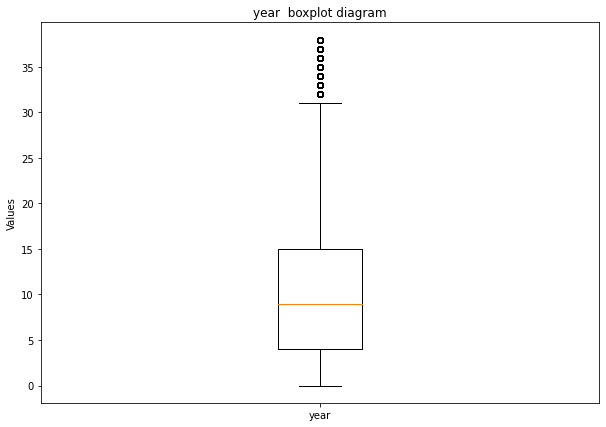

median 9.0 mean 9.89220335731899 min 0.0 max 38.0, total 19596900.0


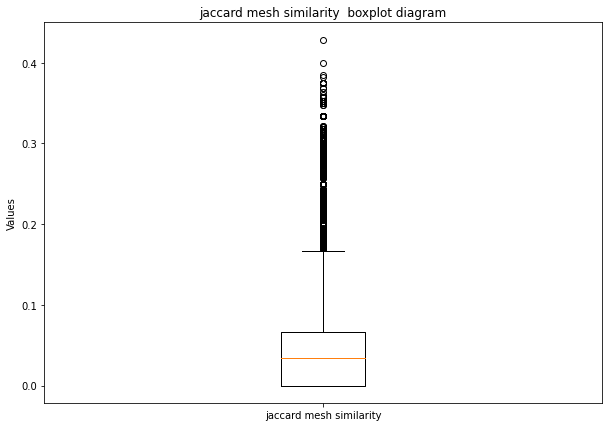

median 0.034482758620689655 mean 0.04003972661167269 min 0.0 max 0.42857142857142855, total 78604.83013196409


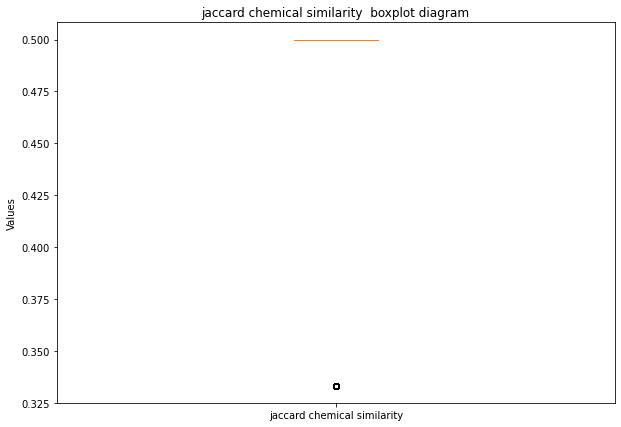

median 0.5 mean 0.4613701560752661 min 0.3333333333333333 max 0.5, total 142334.99999999997


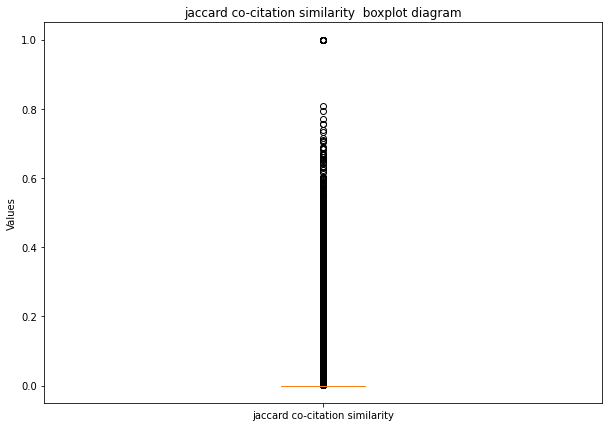

median 0.0 mean 0.008312115093559048 min 0.0 max 1.0, total 16682.46486546357


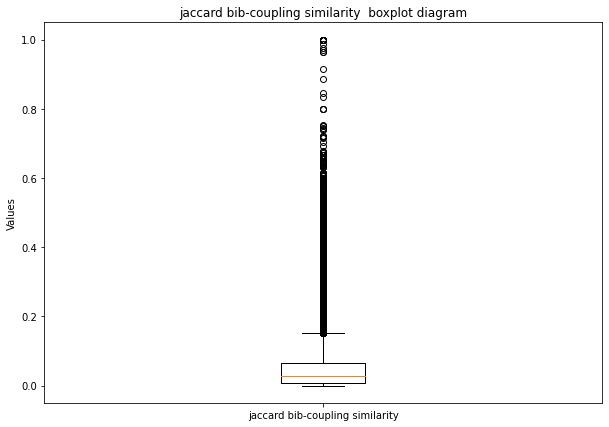

median 0.027972027972027972 mean 0.043887171462283284 min 0.0 max 1.0, total 88081.81644783133


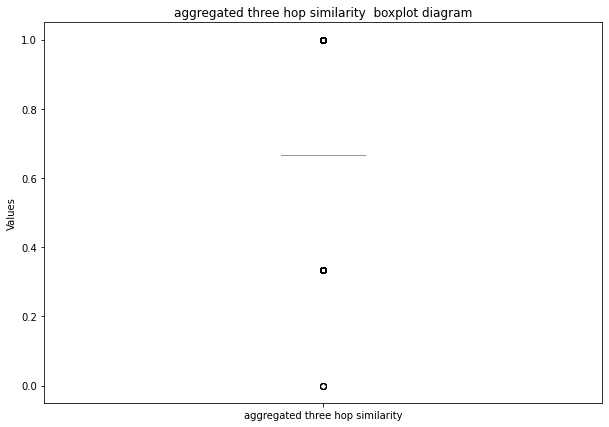

median 0.6666666666666666 mean 0.6413742659463897 min 0.0 max 1.0, total 1287241.9999999998


In [29]:
#Assuming a square matrix, report statistics
def report_matrix_stats(matrix, title):
    n = matrix.shape[0]
    all_values = []
    
    for i in range(n):
        for j in range(i):
            #Remove negatives as they are flags
            if matrix[i][j] > -1:
                all_values.append(matrix[i][j])
    
    report_stats(all_values, title)
    
    
report_matrix_stats(year_distance_matrix, 'year')
report_matrix_stats(mesh_similarity_matrix, 'jaccard mesh similarity')
report_matrix_stats(chemical_similarity_matrix, 'jaccard chemical similarity')
report_matrix_stats(cocitation_similarity_matrix, 'jaccard co-citation similarity')
report_matrix_stats(bib_coupling_similarity_matrix, 'jaccard bib-coupling similarity')
report_matrix_stats(aggregated_three_hop_similarity, 'aggregated three hop similarity')



In [ ]:
#Verify that those entries without grant actually do not have grants
sample_list_of_pmid_without_grant = []
i = 0
with_grants = []

for key, value in all_xmls.items():
    if 'grant' in str(value).lower():
        with_grants.append(key)
    
    else:
        sample_list_of_pmid_without_grant.append(key)
        
    i+= 1
    
    if i == 100:
        break

print('Statistics for first 10 papers:\n')
print(f'PMIDs without grant: {sample_list_of_pmid_without_grant[0:10]}\n')
print(f'PMID of papers with grants {with_grants}')